In [2]:
import os
import pandas as pd
import numpy as np

# from finrl import config_tickers
from finrl.main import check_and_make_directories                               
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

# "./" will be added in front of each directory
check_and_make_directories([TRAINED_MODEL_DIR])


### Step 1: Load all the saved data

In [3]:
train = pd.read_csv('data/train.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

trade = pd.read_csv('data/trade.csv')
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']


In [4]:
trade.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
,,,,,,,,,,,,,,,,,,
0,2022-07-01,136.039993,139.039993,135.660004,137.216949,71051600,AAPL,4,-2.312139,147.798047,126.258563,45.052162,-36.501559,17.058341,138.796890,148.072920,26.700001,29.539152
0,2022-07-01,243.250000,246.000000,240.720001,230.443665,2745500,AMGN,4,0.042000,235.693726,217.654792,53.167820,-7.357142,4.218256,229.728230,229.198783,26.700001,29.539152
0,2022-07-01,138.070007,140.889999,137.470001,136.552689,2625300,AXP,4,-5.951111,165.036113,124.265253,40.059069,-93.759552,37.870137,148.794098,158.616011,26.700001,29.539152
0,2022-07-01,135.880005,141.789993,135.399994,139.839996,7627100,BA,4,0.295126,148.248396,122.092606,47.124452,74.248052,0.310288,132.643000,145.353833,26.700001,29.539152
0,2022-07-01,179.309998,181.320007,173.720001,170.240387,3423100,CAT,4,-8.459092,225.623015,157.577791,37.833413,-137.196198,46.017067,194.803612,200.130089,26.700001,29.539152


In [5]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [6]:
df_account_value_dt = pd.read_pickle('data/df_account_value_dt.pkl')
df_actions_dt = pd.read_pickle('data/df_actions_dt.pkl')


In [7]:
df_account_value_ppo = pd.read_pickle('data/df_account_value_ppo.pkl')
df_actions_ppo = pd.read_pickle('data/df_actions_ppo.pkl')


### Step 2: Mean Variance Optimization

<p align="left">
<img src="images/MVO.png" alt="image" width="400" height="auto">
</p>

In [8]:
# Helps us process data into a form for weight calculation
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

# Calculates weights of average return and covariance matrix
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn


In [9]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()


array([[137.21694946, 230.44366455, 136.5526886 , ...,  44.48649216,
         34.26443481,  39.6645546 ],
       [139.8144989 , 231.55108643, 135.82327271, ...,  44.29696274,
         34.21999741,  40.1885376 ],
       [141.15776062, 230.16213989, 134.36437988, ...,  44.37449646,
         33.57132339,  40.47317123],
       ...,
       [169.46372986, 267.48022461, 236.39587402, ...,  38.58849335,
         17.35797501,  60.00230789],
       [168.87521362, 268.07598877, 234.94021606, ...,  39.04108429,
         17.4566021 ,  59.95248032],
       [173.06466675, 274.43084717, 238.21046448, ...,  39.4444809 ,
         17.77219963,  60.03220749]])

In [10]:
TradeData.head()


,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2022-07-01,137.216949,230.443665,136.552689,139.839996,170.240387,167.719498,39.608242,135.762131,95.387619,282.268127,...,87.516403,255.099289,98.559296,137.967621,164.007812,502.449371,195.699768,44.486492,34.264435,39.664555
2022-07-05,139.814499,231.551086,135.823273,137.699997,165.914902,171.708054,39.364326,132.194565,96.419479,280.353210,...,87.724716,258.312866,101.617973,136.636230,160.194565,490.640717,197.036011,44.296963,34.219997,40.188538
2022-07-06,141.157761,230.162140,134.364380,136.309998,164.530365,172.236557,40.049164,130.452438,95.328087,277.108215,...,88.188728,261.614838,101.530304,137.910995,162.781448,500.400330,197.605865,44.374496,33.571323,40.473171
2022-07-07,144.545471,232.198608,137.165451,139.970001,172.140533,176.135376,40.546383,132.991455,96.667526,281.673889,...,88.075104,263.767029,105.329277,137.863754,162.522781,499.516663,199.256531,44.234924,33.953423,40.534634
2022-07-08,145.226929,233.193420,137.875443,139.070007,171.013840,174.998642,40.705864,132.296463,95.109810,279.664551,...,87.857292,263.039825,105.134460,136.938400,161.919159,503.643799,200.013062,44.043018,33.366943,40.560501


In [11]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)


Mean returns of assets in k-portfolio 1
 [0.131 0.062 0.089 0.067 0.07  0.115 0.052 0.05  0.059 0.063 0.093 0.07
 0.039 0.056 0.049 0.071 0.049 0.059 0.044 0.057 0.097 0.08  0.043 0.06
 0.108 0.097 0.039 0.038 0.039]
Variance-Covariance matrix of returns
 [[3.296 1.026 1.667 1.691 1.53  1.941 1.539 1.161 1.28  1.711 1.31  1.362
  1.116 1.697 0.707 1.68  0.704 0.88  1.139 0.763 1.709 1.368 0.743 0.955
  1.245 1.486 0.592 1.019 0.647]
 [1.026 2.489 1.19  1.025 1.086 1.205 1.044 0.953 0.941 1.139 0.985 1.022
  0.833 1.147 0.888 1.238 0.656 0.677 0.948 1.086 1.109 0.882 0.75  0.884
  1.192 1.04  0.65  1.036 0.635]
 [1.667 1.19  4.853 2.897 2.54  2.004 1.843 2.149 2.208 3.037 1.748 2.23
  1.529 1.939 0.937 3.582 1.106 1.242 1.74  1.107 1.764 1.841 0.93  1.909
  1.706 2.306 0.918 1.448 0.629]
 [1.691 1.025 2.897 5.287 2.373 1.957 1.651 2.167 2.096 2.428 1.645 2.315
  1.557 1.868 0.883 2.616 1.121 1.249 1.586 0.949 1.581 1.795 0.802 1.66
  1.565 1.836 0.769 1.472 0.601]
 [1.53  1.086 2.54  2.

### Step 3: Calculate the efficient frontier to get weights

In [12]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()

# Use shape of 'Last Price' in the range to avoid shape mismatch error
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])

mvo_weights


array([443980.,      0.,      0.,      0.,      0.,  52750.,      0.,
            0.,      0.,      0., 150090.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,   5440.,
            0.,      0.,      0., 265660.,  82090.,      0.,      0.,
            0.])

In [13]:
mvo_weights.shape


(29,)

### Step 4: Apply weights to the last price of our stock data

In [14]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])


In [15]:
LastPrice.shape


(29,)

In [16]:
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Initial_Portfolio


array([3287.908,    0.   ,    0.   ,    0.   ,    0.   ,  320.535,
          0.   ,    0.   ,    0.   ,    0.   ,  576.947,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   21.553,    0.   ,    0.   ,    0.   ,
        532.611,  424.348,    0.   ,    0.   ,    0.   ])

### Step 5: Test our MVO weights on the out-of-sample data

In [17]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

MVO_result


,Mean Var
2022-07-01,1.013792e+06
2022-07-05,1.020502e+06
2022-07-06,1.030517e+06
2022-07-07,1.044884e+06
2022-07-08,1.049143e+06
...,...
2024-04-23,1.212648e+06
2024-04-24,1.217022e+06
2024-04-25,1.221632e+06
2024-04-26,1.222524e+06


### Step 6: DOW JONES Index as Another Baseline

In [18]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2022-07-01'
TRADE_START_DATE = '2022-07-01'
TRADE_END_DATE = '2024-05-01'


In [19]:
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^dji']).fetch_data()


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (460, 8)


In [20]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')


In [28]:
df_result_dt = df_account_value_dt.set_index(df_account_value_dt.columns[0]) #if if_using_a2c else None

result = pd.DataFrame()
dt_result = pd.merge(result, df_result_dt, how='outer', left_index=True, right_index=True)


In [29]:
col_name = []
col_name.append('DT')
dt_result.columns = col_name

In [30]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) #if if_using_a2c else None

result = pd.DataFrame()
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)


In [31]:
col_name = []
col_name.append('PPO')
result.columns = col_name


### Step 7: Merge DataFrames

In [32]:
result = pd.merge(result, dt_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


/tmp/ipykernel_48617/3132867288.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [33]:
result.rename(columns= {'close': 'DJI'}, inplace = True)

#rankings_pd.rename(columns = {'test':'TEST'}, inplace = True)


In [34]:
result


,PPO,DT,Mean Var,DJI
date,,,,
2022-07-01,1.000000e+06,1.000000e+06,1.013792e+06,1.000000e+06
2022-07-05,9.999917e+05,9.999122e+05,1.020502e+06,9.958376e+05
2022-07-06,1.000119e+06,1.000030e+06,1.030517e+06,9.980841e+05
2022-07-07,1.000674e+06,1.000406e+06,1.044884e+06,1.009238e+06
2022-07-08,1.000482e+06,1.000247e+06,1.049143e+06,1.007746e+06
...,...,...,...,...
2024-04-24,1.205110e+06,1.243368e+06,1.217022e+06,1.236795e+06
2024-04-25,1.201557e+06,1.240114e+06,1.221632e+06,1.224732e+06
2024-04-26,1.196589e+06,1.236476e+06,1.222524e+06,1.229679e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

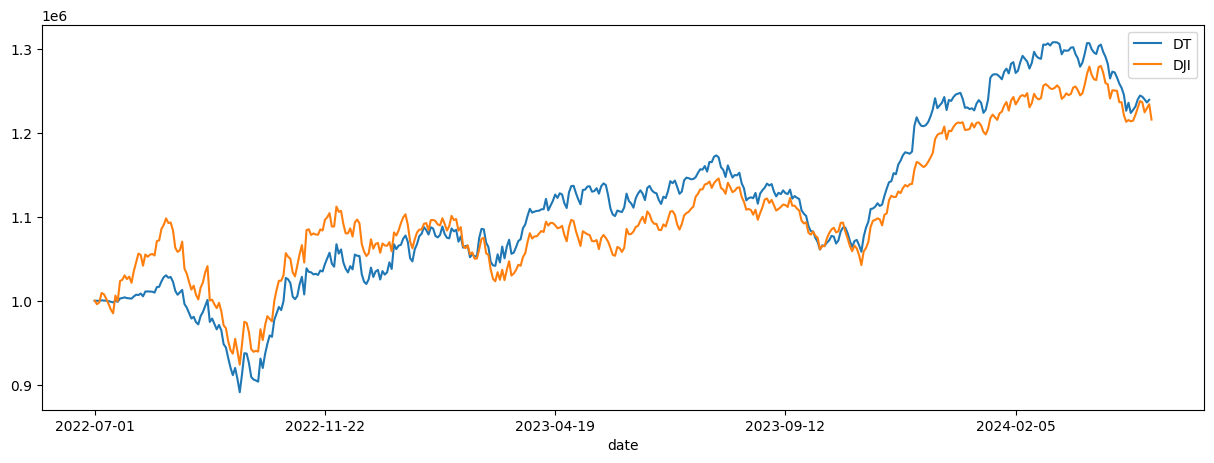

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result[['DT', 'DJI']].plot()


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

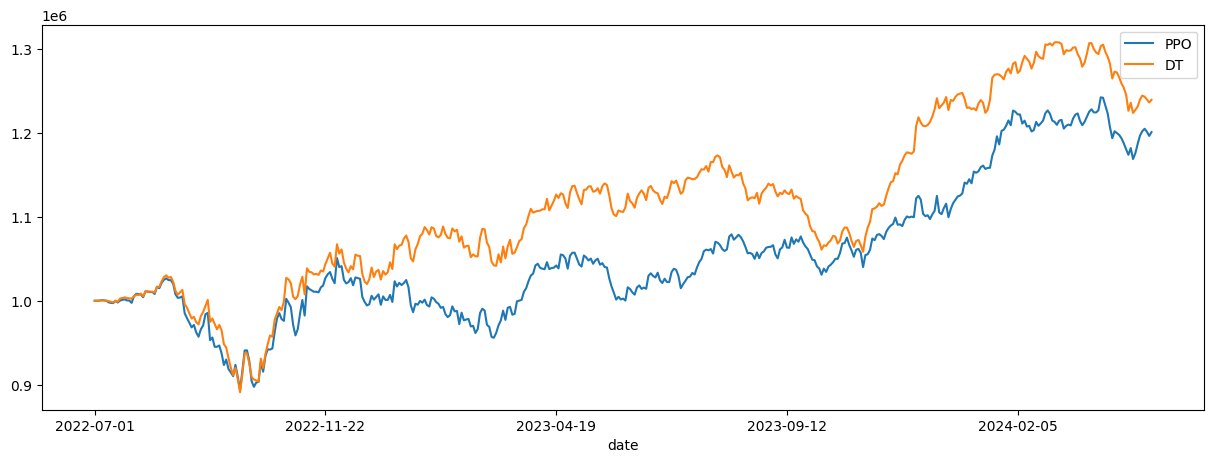

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result[['PPO', 'DT']].plot()


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

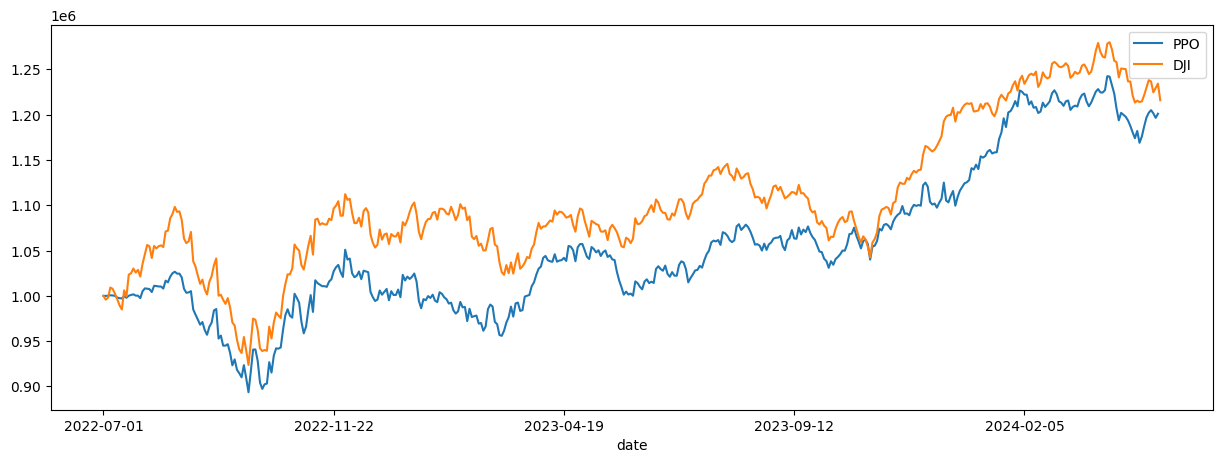

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result[['PPO', 'DJI']].plot()


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

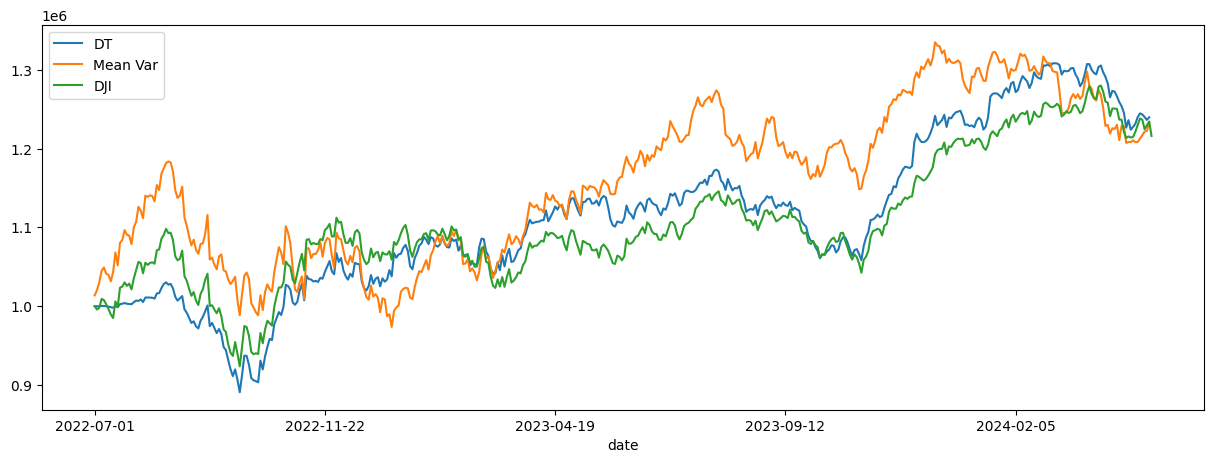

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.iloc[:, 1:4].plot()
